# 2.1.2: Analysis of the area of applicability across trait sets

A major motivation for the inclusion of GBIF data in the model training pipeline was to expand the geospatial extent of the feature space at training time in hopes that it would be more similar to the feature space at inference time. In other words, including training data that comes from a broader range of environmental conditions should result in a higher area of applicability than models trained on a smaller, sparser dataset. To assess this, we can simply compare the overall geographic extent covered by the AOA masks of the sPlot, combined (sPlot + GBIF) models.

## Imports and config

In [1]:
import pandas as pd

from src.conf.conf import get_config
from src.conf.environment import log

cfg = get_config()

## Compare AOA

Load the results.

In [2]:
all_res = pd.read_parquet("results/all_results.parquet")

Filter out models that have an $R^2$ lower than 0.2.

In [3]:
filt_res = all_res.query(
    "transform == 'none' and "
    "(trait_set == 'splot_gbif' or trait_set == 'splot') and "
    "r2 >= 0.2"
)

resolutions = filt_res.resolution.unique()

# Filter out models where we don't have both a splot and splot_gbif model
for res in resolutions:
    res_res = filt_res.query(f"resolution == '{res}'")
    splot_traits = res_res.query("trait_set == 'splot'").trait_id.unique()
    comb_traits = res_res.query("trait_set == 'splot_gbif'").trait_id.unique()

    # Identify the traits that are in both sets
    common_traits = set(splot_traits).intersection(set(comb_traits))

    # Filter out the models that don't have both trait sets
    filt_res = filt_res.query(
        f"not (resolution == '{res}' and trait_set == 'splot' and trait_id not in {list(common_traits)})"
    )

Plot the AOAs in a scatterplot

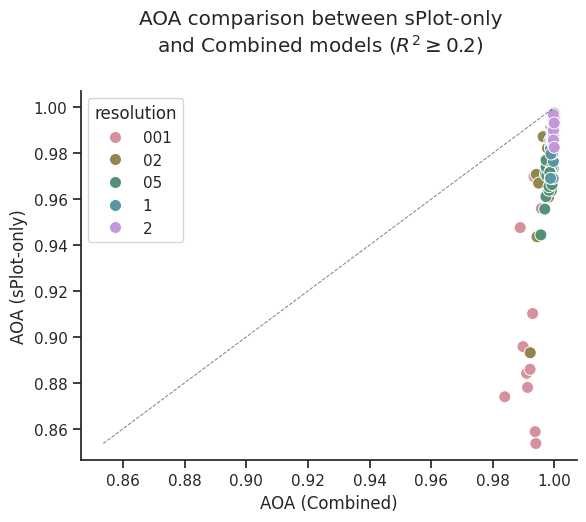

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

resolutions = filt_res.resolution.unique()
data = pd.DataFrame()

for res in resolutions:
    res_res = filt_res.query(f"resolution == '{res}'")
    splot = res_res.query("trait_set == 'splot'").set_index("trait_id")["aoa"]
    comb = res_res.query("trait_set == 'splot_gbif'").set_index("trait_id")["aoa"]

    merged = pd.merge(
        splot, comb, left_index=True, right_index=True, suffixes=("_splot", "_comb")
    )
    merged["resolution"] = res
    data = pd.concat([data, merged], ignore_index=True).sort_values(
        "resolution", ascending=True
    )

with sns.plotting_context("notebook"), sns.axes_style("ticks"):
    palette = sns.color_palette("husl", n_colors=len(resolutions), desat=0.5)
    fig, ax = plt.subplots()
    sns.scatterplot(
        data=data,
        x="aoa_comb",
        y="aoa_splot",
        hue="resolution",
        palette=palette,
        ax=ax,
        s=75,
    )

    # include a 1:1 line
    p1 = min(data["aoa_splot"].min(), data["aoa_comb"].min())
    p2 = max(data["aoa_splot"].max(), data["aoa_comb"].max())
    ax.plot([p1, p2], [p1, p2], color="black", linestyle="--", alpha=0.5, lw=0.7)

    ax.set_xlabel("AOA (Combined)")
    ax.set_ylabel("AOA (sPlot-only)")

    fig.suptitle(
        "AOA comparison between sPlot-only\nand Combined models ($R^2 \\geq 0.2$)", y=1.05
    )
    sns.despine()